In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, GlobalMaxPool1D

## Loading and Preprocessing of the Dataset

The dataset used for the project is then loaded from the csv file into a pandas dataframe.

In [2]:
counseldf = pd.read_csv(r"C:\Users\amitu\Minor Project\counselchat-data.csv")

The below function prints the columns available within the dataset.

In [3]:
print(counseldf.columns)

Index(['questionID', 'questionTitle', 'questionText', 'questionUrl', 'topics',
       'therapistName', 'therapistUrl', 'answerText', 'upvotes'],
      dtype='object')


Below the first 5 samples within the dataset are displayed.

In [4]:
counseldf.head()

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,My wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>What you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"I'm planning to have baby, so I have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi. Good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"I have secrets in my mind, and I don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>It sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,I am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>Hi there. It's great you are able to realiz...,0
4,556ba115c969ba5861709de6,Can I control anxiety without medication?,I had a head injury a few years ago and my min...,https://counselchat.com/questions/can-i-contro...,Anxiety,Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>You didn't say what or how many medications...,0


As the dataset contains some columns with personal information about the therapist, those columns are removed. Moreover, for the purposes of this project the only relevant columns are 'questionText' and 'topics'. Hence all other columns except those are removed before further processing.

In [5]:
counseldf.drop(['questionID', 'questionTitle', 'questionUrl', 'therapistName', 'therapistUrl','answerText', 'upvotes'], axis = 1, inplace=True)

In [6]:
counseldf.head()

,questionText,topics
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...","Substance Abuse,Addiction"
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,"Behavioral Change,Social Relationships"
4,I had a head injury a few years ago and my min...,Anxiety


In [7]:
counseldf.shape

(1482, 2)

In [8]:
counseldf.isnull().sum()

questionText    99
topics          10
dtype: int64

The datset contains some null values in both columns. To avoid the problem created by null values, the samples containing them are simply removed.

In [9]:
counseldf = counseldf.dropna(axis=0)

In [10]:
counseldf.isnull().sum()

questionText    0
topics          0
dtype: int64

In [11]:
counseldf.shape

(1376, 2)

Finally, we have the clean dataset which can now be processed with NLP techniques. After removing rows with null values, the size of the dataset remains at 1376 samples.

The 'topics' column is the target categories for the samples. As seen in the first few lines, some of the samples contain multiple labels. An LSTM network was tried to train using multiple labels but as the model failed to converge, it was decided that only the first label would be kept as the target label of the sample if it has multiple labels. The below code does just that.

In [12]:
counseldf['topics'] = counseldf['topics'].str.split(',')
counseldf['topics'] = counseldf['topics'].apply(lambda x: x[0])

In [13]:
counseldf.head()

,questionText,topics
0,My wife and mother are having tense disagreeme...,Family Conflict
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse
2,"I have secrets in my mind, and I don't know wh...",Family Conflict
3,I am extremely possessive in my relationships ...,Behavioral Change
4,I had a head injury a few years ago and my min...,Anxiety


In [14]:
counseldf['topics'].value_counts()

topics
Relationships                246
Anxiety                      178
Family Conflict              113
Depression                    97
Marriage                      89
Self-esteem                   64
Parenting                     59
Trauma                        51
Human Sexuality               45
Behavioral Change             43
Intimacy                      42
Relationship Dissolution      42
Counseling Fundamentals       39
Social Relationships          38
Anger Management              31
Professional Ethics           28
LGBTQ                         24
Stress                        24
Spirituality                  19
Addiction                     14
Grief and Loss                14
Substance Abuse               14
Legal & Regulatory            11
Sleep Improvement             10
Diagnosis                     10
Domestic Violence              9
Workplace Relationships        8
Eating Disorders               4
Military Issues                3
Children & Adolescents         3
Car

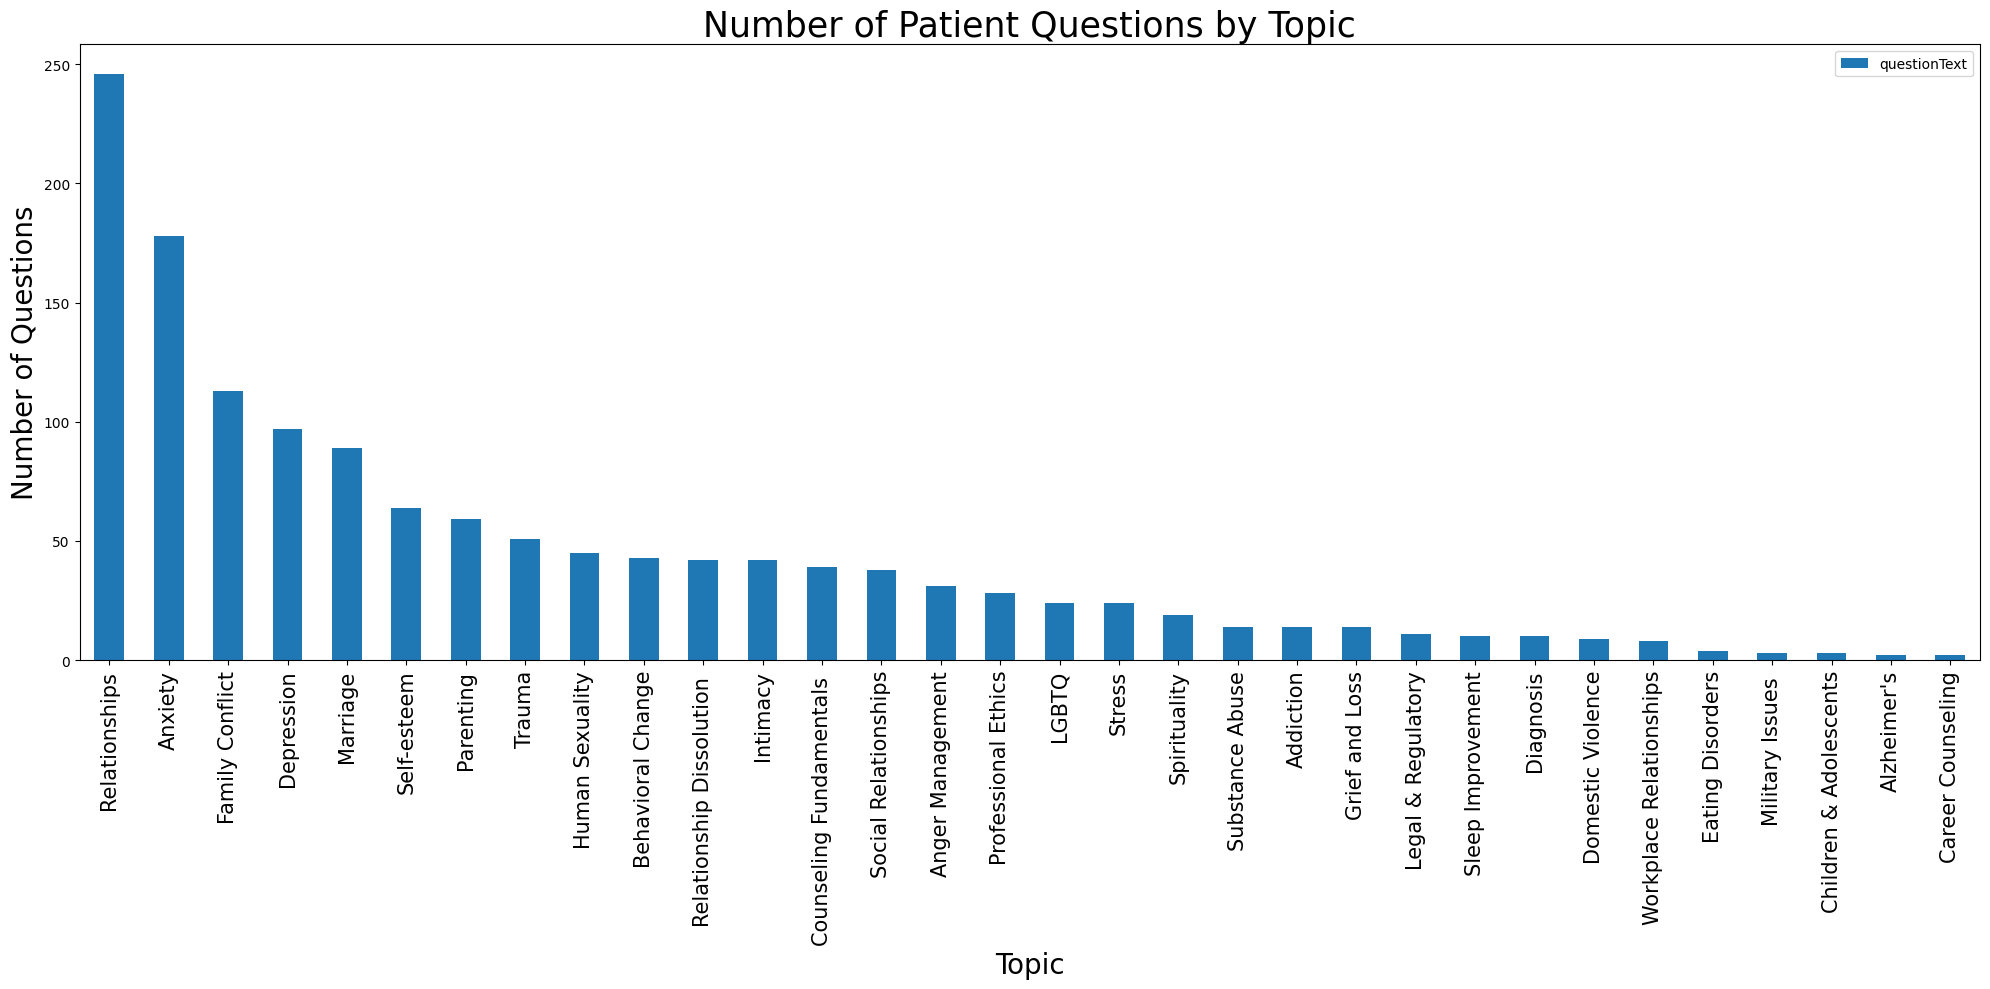

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
counseldf.groupby('topics').agg('count').sort_values('questionText', ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Patient Questions by Topic", fontsize=25)
ax.set_ylabel("Number of Questions", fontsize=20)
ax.set_xlabel("Topic", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
plt.tight_layout()
plt.show()

After this initial analysis to look at the overall dataset, the 'topics' column could be one-hot encoded so that it is ready for the learning model to take as targets.

In [16]:
targetdf = pd.get_dummies(counseldf['topics'])
targetdf.head()

,Addiction,Alzheimer's,Anger Management,Anxiety,Behavioral Change,Career Counseling,Children & Adolescents,Counseling Fundamentals,Depression,Diagnosis,...,Relationship Dissolution,Relationships,Self-esteem,Sleep Improvement,Social Relationships,Spirituality,Stress,Substance Abuse,Trauma,Workplace Relationships
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Distribution of Question Lengths')

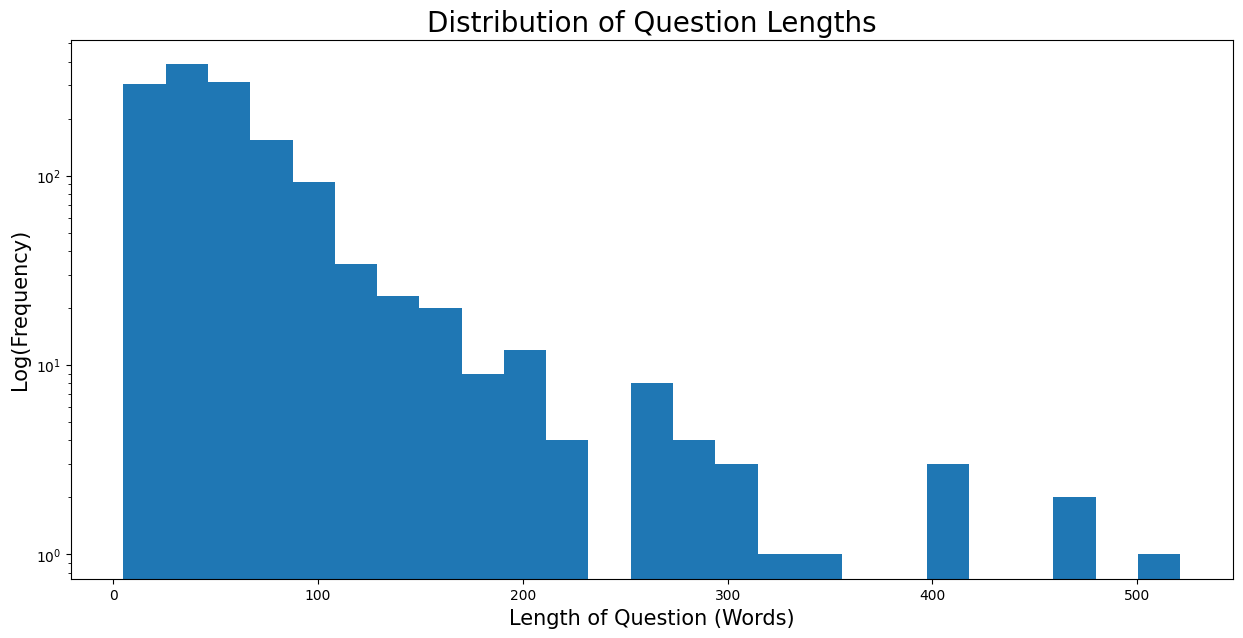

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))

# Average Length of Question
counseldf["questionLength"] = counseldf["questionText"].apply(lambda x: len(x.split(" ")))
counseldf["questionLength"].astype(int).plot.hist(bins=25, ax=axs, logy=True)
axs.set_xlabel("Length of Question (Words)", fontsize=15)
axs.set_ylabel("Log(Frequency)", fontsize=15)
axs.set_title("Distribution of Question Lengths", fontsize=20)





In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amitu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now, finally it is time to apply natural language processing techniques to each of the individual text samples.

First, we define a pre-process function.

## Stopwords Removal and Normalisation

In [19]:
#Preprocess function


import nltk, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

stop_words = stopwords.words('english')
normalizer = WordNetLemmatizer()

def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

def preprocess_text(text):
    cleaned = re.sub(r'\W+', ' ', text).lower()
    tokenized = word_tokenize(cleaned)
    normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    return normalized

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amitu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amitu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amitu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The few cells below show the NLP pre-processing techniques applied to the first samples of text.

In [20]:
counseldf['questionText'][0]

'My wife and mother are having tense disagreements. In the past, they’ve had minor differences. For example, my wife would complain to me my mother is too overbearing; my mother would complain my wife is lazy.\nHowever, it’s intensified lately. I think the cause is my wife talked back to her once. Now, any little disagreement is magnified, leading to major disagreements. What can I do?'

In [21]:
text = counseldf['questionText'][0]
cleaned = re.sub(r'\W+', ' ', text).lower()
print(cleaned)

my wife and mother are having tense disagreements in the past they ve had minor differences for example my wife would complain to me my mother is too overbearing my mother would complain my wife is lazy however it s intensified lately i think the cause is my wife talked back to her once now any little disagreement is magnified leading to major disagreements what can i do 


## Tokenizer

In [22]:
tokenized = word_tokenize(cleaned)
print(tokenized)

['my', 'wife', 'and', 'mother', 'are', 'having', 'tense', 'disagreements', 'in', 'the', 'past', 'they', 've', 'had', 'minor', 'differences', 'for', 'example', 'my', 'wife', 'would', 'complain', 'to', 'me', 'my', 'mother', 'is', 'too', 'overbearing', 'my', 'mother', 'would', 'complain', 'my', 'wife', 'is', 'lazy', 'however', 'it', 's', 'intensified', 'lately', 'i', 'think', 'the', 'cause', 'is', 'my', 'wife', 'talked', 'back', 'to', 'her', 'once', 'now', 'any', 'little', 'disagreement', 'is', 'magnified', 'leading', 'to', 'major', 'disagreements', 'what', 'can', 'i', 'do']


## normalizer

In [23]:
normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
print(normalized)

['my', 'wife', 'and', 'mother', 'be', 'have', 'tense', 'disagreement', 'in', 'the', 'past', 'they', 've', 'have', 'minor', 'difference', 'for', 'example', 'my', 'wife', 'would', 'complain', 'to', 'me', 'my', 'mother', 'be', 'too', 'overbear', 'my', 'mother', 'would', 'complain', 'my', 'wife', 'be', 'lazy', 'however', 'it', 's', 'intensify', 'lately', 'i', 'think', 'the', 'cause', 'be', 'my', 'wife', 'talk', 'back', 'to', 'her', 'once', 'now', 'any', 'little', 'disagreement', 'be', 'magnify', 'lead', 'to', 'major', 'disagreement', 'what', 'can', 'i', 'do']


It is clear from the above few cells what pre-processing does to each of the samples. Below the same process is applied to the entire dataset calling the pre-process function defined above.

## Stop words Removal

In [24]:
processed_questionText = counseldf['questionText'].apply(lambda x: preprocess_text(x))

After pre-processing, stop words removal can be done to each of the samples.

In [25]:
stop_words = set(stopwords.words('english'))

questionText_nostops = []
for title in processed_questionText:
    text_no_stops = [word for word in title if word not in stop_words]
    questionText_nostops.append(text_no_stops)

Below is the first sample with stop words removed.

In [26]:
print(questionText_nostops[0])

['wife', 'mother', 'tense', 'disagreement', 'past', 'minor', 'difference', 'example', 'wife', 'would', 'complain', 'mother', 'overbear', 'mother', 'would', 'complain', 'wife', 'lazy', 'however', 'intensify', 'lately', 'think', 'cause', 'wife', 'talk', 'back', 'little', 'disagreement', 'magnify', 'lead', 'major', 'disagreement']


Finally, with the tokens available for all samples, it is time to create the word-index dictionary for changing the data to numerical values. To do this, Tensorflow's tokenizer class will be used.

In [27]:
from keras.preprocessing.text import Tokenizer

In [28]:
from keras.preprocessing import sequence

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts( questionText_nostops ) 
tokenized_questions = tokenizer.texts_to_sequences( questionText_nostops ) 
word_index = tokenizer.word_index
print('Sample tokenized: {}'.format(tokenized_questions[0]))
print('==================================================================================================================\n')

length_list = list()
for token_seq in tokenized_questions:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Questions max length is {} words'.format( max_input_length ))
print('==================================================================================================================\n')

padded_questions = sequence.pad_sequences( tokenized_questions , maxlen=max_input_length , padding='post' )
input_data = np.array( padded_questions )
print( 'Input data shape -> {}\n'.format( input_data.shape ))
print('Input data sample->\n {}'.format(input_data[0]))
print('==================================================================================================================\n')

question_word_dict = tokenizer.word_index
num_question_tokens = len( question_word_dict )+1
print( 'Number of Question tokens = {}\n'.format( num_question_tokens))
print('Dictionary: {}'.format(question_word_dict))

Sample tokenized: [68, 101, 1760, 971, 49, 858, 972, 684, 68, 52, 477, 101, 1761, 101, 52, 477, 68, 859, 165, 1386, 150, 9, 216, 68, 18, 41, 166, 971, 1762, 353, 626, 971]

Questions max length is 220 words

Input data shape -> (1376, 220)

Input data sample->
 [  68  101 1760  971   49  858  972  684   68   52  477  101 1761  101
   52  477   68  859  165 1386  150    9  216   68   18   41  166  971
 1762  353  626  971    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

## Word Embedding - Glove Embeddings

In [30]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('test_glove.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)
model

C:\Users\amitu\AppData\Local\Temp\ipykernel_32924\1973302.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [31]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-50")  # download the model and return as object ready for use
model.most_similar("angry")

[('stupid', 0.8132888078689575),
 ('confused', 0.7932010293006897),
 ('birds', 0.7878215909004211),
 ('weird', 0.7833624482154846),
 ('annoying', 0.7818509340286255),
 ('sometimes', 0.7801089882850647),
 ('mad', 0.7680051326751709),
 ('scared', 0.766951322555542),
 ('bit', 0.7651330232620239),
 ('feel', 0.7628020644187927)]

In [32]:
model.most_similar('lonely')

[('depressed', 0.8324964046478271),
 ('alone', 0.8142210841178894),
 ('quiet', 0.8037996888160706),
 ('confused', 0.7911059856414795),
 ('feel', 0.7875390648841858),
 ('lazy', 0.7828732132911682),
 ('sad', 0.7816170454025269),
 ('tired', 0.778805673122406),
 ('sleeping', 0.7786440253257751),
 ('paranoid', 0.7720916867256165)]

In [33]:
result = model.most_similar(positive=['angry', 'sad'], topn=5)
result

[('confused', 0.8751622438430786),
 ('feel', 0.8701820969581604),
 ('bad', 0.8548141717910767),
 ('weird', 0.8539324998855591),
 ('stupid', 0.8476240038871765)]

In [34]:
from gensim.models import Word2Vec


vocab=list(model.index_to_key)
index_of_words = len(vocab)
print(index_of_words)
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=model[word]
print("The no of key-value pairs : ",len(word_vec_dict))

1193514
The no of key-value pairs :  1193514


In [35]:
import numpy as np
# Initialize embedding matrix
embed_matrix = np.zeros(shape=(len(vocab), 25))

# Loop through word_index.items()
for word, i in word_index.items():
    embed_vector = word_vec_dict.get(word)
    if embed_vector is not None:
        embed_vector = np.resize(embed_vector, (25,))
        # Ensure the index is within bounds before assigning the embed_vector
        embed_matrix[i] = embed_vector

# The resulting embed_matrix should have non-zero rows for words found in the pre-trained word vectors.

In [36]:
import tensorflow as tf
from tensorflow.keras import preprocessing

tf.random.set_seed(4)
tf.__version__

'2.15.0'

Finally, with the input data ready with the numerical token indices, it is time to split the dataset into training and testing sets.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
x_train, x_test, y_train, y_test = train_test_split(input_data, targetdf, test_size = 0.2, random_state=2)

In [39]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1100, 220) (276, 220)
(1100, 32) (276, 32)


Finally, in the below cell, the bi-directional LSTM model is defined.

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
vocab_size = index_of_words
# Embedding layer before the actaul LSTM 
embedd_layer = tf.keras.layers.Embedding(vocab_size,25,input_length = max_input_length,weights = [embed_matrix],trainable=False)
# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(100, dropout=0.1,return_state=False), name='bidir'))
model.add(Dense(500, activation=tf.keras.activations.relu))
model.add(Dense(32, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy','Precision','Recall'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 220, 25)           29837850  
                                                                 
 bidir (Bidirectional)       (None, 200)               100800    
                                                                 
 dense (Dense)               (None, 500)               100500    
                                                                 
 dense_1 (Dense)             (None, 32)                16032     
                                                                 
Total params: 30055182 (114.65 MB)
Trainable params: 217332 (848.95 KB)
Non-trainable params: 29837850 (113.82 MB)
_________________________________________________________________


## Model Architecture

In [41]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
vocab_size = index_of_words
# Embedding layer before the actaul LSTM 
embedd_layer = tf.keras.layers.Embedding(vocab_size,25,input_length = max_input_length,weights = [embed_matrix],trainable=False)
# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(100, dropout=0.1,return_state=False), name='bidir'))
model.add(Dense(500, activation=tf.keras.activations.relu))
model.add(Dense(32, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy','Precision','Recall'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 220, 25)           29837850  
                                                                 
 bidir (Bidirectional)       (None, 200)               100800    
                                                                 
 dense_2 (Dense)             (None, 500)               100500    
                                                                 
 dense_3 (Dense)             (None, 32)                16032     
                                                                 
Total params: 30055182 (114.65 MB)
Trainable params: 217332 (848.95 KB)
Non-trainable params: 29837850 (113.82 MB)
_________________________________________________________________


In [43]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from tensorflow.keras.utils import plot_model

In [45]:
tf.keras.utils.plot_model(
    model, to_file=r'C:\Users\amitu\Minor Project\Final_LSTM_model.h5', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
#history = LSTM_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=50, verbose=1)
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=30, verbose=1)

Epoch 1/30
9/9 [==============================] - 6s 714ms/step - loss: 2.3393 - accuracy: 0.3273 - precision: 0.7222 - recall: 0.0355 - val_loss: 2.4512 - val_accuracy: 0.2935 - val_precision: 0.8333 - val_recall: 0.0725
Epoch 2/30
9/9 [==============================] - 6s 673ms/step - loss: 2.2456 - accuracy: 0.3364 - precision: 0.8506 - recall: 0.0673 - val_loss: 2.4120 - val_accuracy: 0.3007 - val_precision: 0.9286 - val_recall: 0.0942
Epoch 3/30
9/9 [==============================] - 7s 809ms/step - loss: 2.1343 - accuracy: 0.3782 - precision: 0.8209 - recall: 0.1000 - val_loss: 2.3423 - val_accuracy: 0.3333 - val_precision: 0.6061 - val_recall: 0.1449
Epoch 4/30
9/9 [==============================] - 6s 679ms/step - loss: 2.0532 - accuracy: 0.3818 - precision: 0.8182 - recall: 0.1145 - val_loss: 2.3172 - val_accuracy: 0.3551 - val_precision: 0.6250 - val_recall: 0.1268
Epoch 5/30
9/9 [==============================] - 6s 697ms/step - loss: 2.0063 - accuracy: 0.4182 - precision: 0

## Model Performance

In [48]:
history_df = pd.DataFrame(hist.history)
history_df['f1_score'] = (2 * history_df['precision']*history_df['recall'])/(history_df['precision']+history_df['recall'])
history_df['val_f1_score'] = (2 * history_df['val_precision']*history_df['val_recall'])/(history_df['val_precision']+history_df['val_recall'])

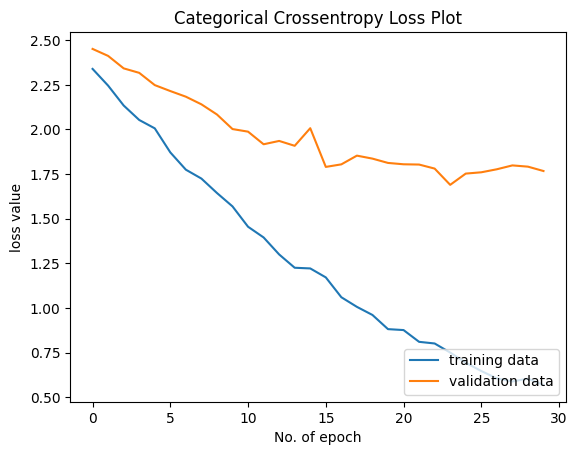

In [49]:
plt.plot(hist.history['loss'], label='training data')
plt.plot(hist.history['val_loss'], label='validation data')
plt.title('Categorical Crossentropy Loss Plot')
plt.ylabel('loss value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")
plt.show()

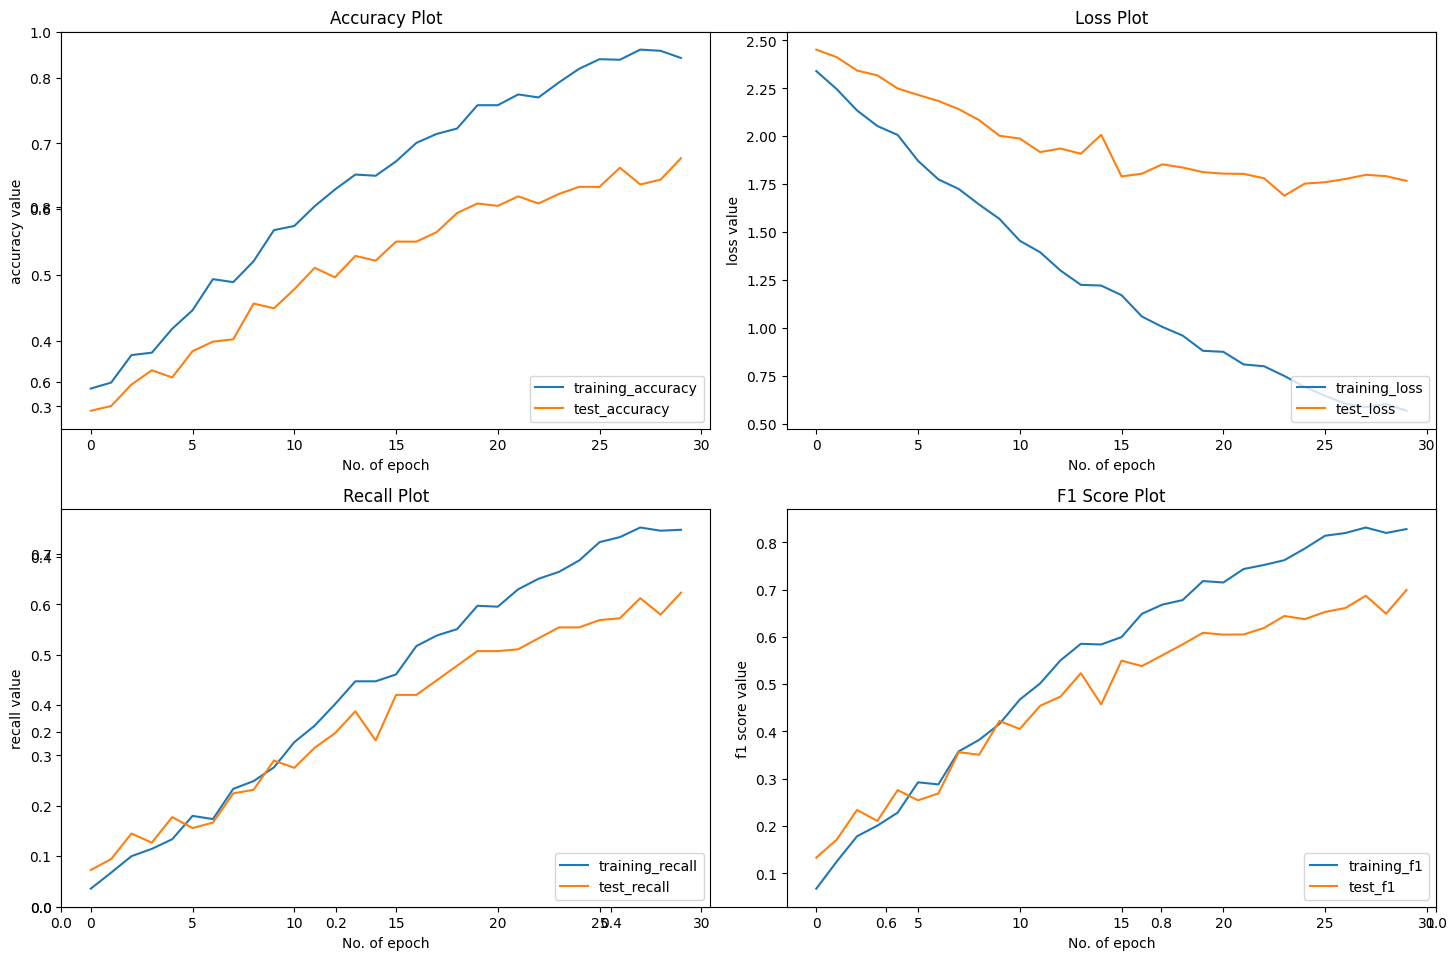

In [50]:
plt.subplots(figsize=(15,10))
ax = plt.subplot(2,2,1)
plt.plot(hist.history['accuracy'], label='training_accuracy')
plt.plot(hist.history['val_accuracy'], label='test_accuracy')
plt.title('Accuracy Plot')
plt.ylabel('accuracy value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,2)
plt.plot(hist.history['loss'], label='training_loss')
plt.plot(hist.history['val_loss'], label='test_loss')
plt.title('Loss Plot')
plt.ylabel('loss value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,3)
plt.plot(hist.history['recall'], label='training_recall')
plt.plot(hist.history['val_recall'], label='test_recall')
plt.title('Recall Plot')
plt.ylabel('recall value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

ax = plt.subplot(2,2,4)
plt.plot(history_df['f1_score'], label='training_f1')
plt.plot(history_df['val_f1_score'], label='test_f1')
plt.title('F1 Score Plot')
plt.ylabel('f1 score value')
plt.xlabel('No. of epoch')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [51]:
history_df['f1_score']

0     0.067591
1     0.124684
2     0.178282
3     0.200957
4     0.228438
5     0.292467
6     0.288084
7     0.357939
8     0.382148
9     0.415869
10    0.467448
11    0.501587
12    0.550436
13    0.585366
14    0.583976
15    0.599645
16    0.648803
17    0.668172
18    0.677852
19    0.718033
20    0.715066
21    0.743562
22    0.752101
23    0.762252
24    0.786681
25    0.813906
26    0.819705
27    0.831325
28    0.819770
29    0.827968
Name: f1_score, dtype: float64

In [52]:
history_df['val_f1_score']

0     0.133333
1     0.171053
2     0.233918
3     0.210843
4     0.276056
5     0.254438
6     0.269006
7     0.356322
8     0.350685
9     0.422164
10    0.405333
11    0.454308
12    0.473815
13    0.523227
14    0.457286
15    0.549763
16    0.538283
17    0.561086
18    0.584071
19    0.608696
20    0.604752
21    0.605150
22    0.618947
23    0.644211
24    0.637500
25    0.652807
26    0.661088
27    0.686992
28    0.649087
29    0.699187
Name: val_f1_score, dtype: float64

In [53]:
from sklearn.metrics import f1_score


## Prediction

Below, a predict function is defined that will take as input natural language text and try to classify it into the categories of mental health issues defined from the dataset.

In [54]:
model = tf.keras.models.load_model(r"C:\Users\amitu\Minor Project\Final_LSTM_model.h5")

In [55]:
def predict(text):
    processed = preprocess_text(text)
    text_no_stops = [word for word in processed if word not in stop_words]
    tokenized = tokenizer.texts_to_sequences( text_no_stops )
    padded = preprocessing.sequence.pad_sequences( tokenized , maxlen=max_input_length , padding='post' )
    input_data = np.array( padded )
    output = model.predict(input_data)
    index = np.argmax(output[0])
    return (targetdf.columns[index])

In [56]:
sent = ['I break out in cold sweat. I have panic attaks and bad dreams at night.',
        'I am constantly worried about my work future.',
        'I am very sad and depressed. I want to commit suicide.',
        'My husband and I have constant arguments. I want to get a divorce',
        'I am very angry all the time. I smash things in anger']

In [57]:
for i in sent:
    print(predict(i))

1/1 [==============================] - 7s 7s/step
Human Sexuality
1/1 [==============================] - 0s 118ms/step
Career Counseling
1/1 [==============================] - 0s 110ms/step
Marriage
1/1 [==============================] - 0s 75ms/step
Legal & Regulatory
1/1 [==============================] - 0s 72ms/step
Human Sexuality


In [58]:
pred = []
for index,rows in counseldf.iterrows():
    pred.append(predict(rows['questionText']))

1/1 [==============================] - 0s 115ms/step


In [59]:
counseldf['predict'] = pred

In [60]:
counseldf.head()

,questionText,topics,questionLength,predict
0,My wife and mother are having tense disagreeme...,Family Conflict,65,Career Counseling
1,"I'm planning to have baby, so I have to quit s...",Substance Abuse,40,Substance Abuse
2,"I have secrets in my mind, and I don't know wh...",Family Conflict,58,Social Relationships
3,I am extremely possessive in my relationships ...,Behavioral Change,20,Human Sexuality
4,I had a head injury a few years ago and my min...,Anxiety,57,Substance Abuse


In [61]:
counseldf.topics.value_counts()

topics
Relationships                246
Anxiety                      178
Family Conflict              113
Depression                    97
Marriage                      89
Self-esteem                   64
Parenting                     59
Trauma                        51
Human Sexuality               45
Behavioral Change             43
Intimacy                      42
Relationship Dissolution      42
Counseling Fundamentals       39
Social Relationships          38
Anger Management              31
Professional Ethics           28
LGBTQ                         24
Stress                        24
Spirituality                  19
Addiction                     14
Grief and Loss                14
Substance Abuse               14
Legal & Regulatory            11
Sleep Improvement             10
Diagnosis                     10
Domestic Violence              9
Workplace Relationships        8
Eating Disorders               4
Military Issues                3
Children & Adolescents         3
Car

In [62]:
counseldf.predict.value_counts()

predict
LGBTQ                        357
Career Counseling            341
Behavioral Change            154
Legal & Regulatory           136
Marriage                      79
Substance Abuse               76
Spirituality                  45
Human Sexuality               38
Counseling Fundamentals       30
Alzheimer's                   23
Depression                    22
Family Conflict               21
Grief and Loss                 9
Children & Adolescents         8
Relationship Dissolution       8
Social Relationships           8
Diagnosis                      5
Military Issues                4
Anger Management               4
Relationships                  4
Stress                         3
Intimacy                       1
Name: count, dtype: int64

In [63]:
model.save('glove_model2.h5')

C:\Users\amitu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We saved the word2vec model which was trained for 30 epochs

In [64]:
from sklearn.metrics import classification_report
print(classification_report(counseldf.topics, counseldf.predict))

C:\Users\amitu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                Addiction       0.00      0.00      0.00        14
              Alzheimer's       0.00      0.00      0.00         2
         Anger Management       0.00      0.00      0.00        31
                  Anxiety       0.00      0.00      0.00       178
        Behavioral Change       0.04      0.14      0.06        43
        Career Counseling       0.01      1.00      0.01         2
   Children & Adolescents       0.00      0.00      0.00         3
 Counseling Fundamentals        0.03      0.03      0.03        39
               Depression       0.05      0.01      0.02        97
                Diagnosis       0.00      0.00      0.00        10
        Domestic Violence       0.00      0.00      0.00         9
         Eating Disorders       0.00      0.00      0.00         4
          Family Conflict       0.05      0.01      0.01       113
           Grief and Loss       0.00      0.00      0.00     

C:\Users\amitu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amitu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
